In [2]:
import transformers
import torch
from transformers import WhisperFeatureExtractor, set_seed, AutoModelForAudioClassification
import datasets
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
import pandas as pd
from tqdm import tqdm
import numpy as np
import librosa
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
tqdm.pandas()
set_seed(55)

# Read audio

In [3]:
def read_audio(path):
    try:
        audio, sample_rate = librosa.load(path, sr=16000)
        return audio
    except:
        return np.array([])

In [4]:
manifest = pd.read_excel('manifest_balanced.xlsx')
variants = ['Arkhangelskie', 'Novgorodskie', 'Povolzkie', 'Pskovskie', 'Ryazanskie']
manifest = manifest[manifest['Variant'].isin(variants)]
manifest = manifest[['path', 'Variant', 'text', 'informant']]
manifest['array'] = manifest['path'].progress_apply(read_audio)
manifest['sampling_rate'] = 16000

100%|████████████████████████████████████████████████████████████████████████████| 25806/25806 [32:27<00:00, 13.25it/s]


# Split on train, validation and test (speakers fixed)

In [5]:
manifest = manifest[['path', 'Variant', 'array', 'sampling_rate', 'informant']]
train = pd.DataFrame()
valid = pd.DataFrame()
test = pd.DataFrame()
variants = ['Arkhangelskie', 'Novgorodskie', 'Povolzkie', 'Pskovskie', 'Ryazanskie']
for variant in variants:
    speaker_counts = manifest[manifest['Variant']==variant]['informant'].value_counts().to_dict()
    total_records = len(manifest[manifest['Variant']==variant]['path'])
    train_target = 0.7 * total_records
    val_target = 0.165 * total_records
    test_target = total_records - train_target - val_target
    speaker_ids = list(speaker_counts.keys())
    train_speakers, val_speakers, test_speakers = [], [], []
    train_sum = val_sum = test_sum = 0
    for speaker in speaker_ids:
        count = speaker_counts[speaker]
        if train_sum + count <= train_target:
            train_speakers.append(speaker)
            train_sum += count
        elif val_sum + count <= val_target:
            val_speakers.append(speaker)
            val_sum += count
        else:
            test_speakers.append(speaker)
            test_sum += count
    train_df = manifest[(manifest['Variant']==variant)&(manifest['informant'].isin(train_speakers))]
    valid_df = manifest[(manifest['Variant']==variant)&(manifest['informant'].isin(val_speakers))]
    test_df = manifest[(manifest['Variant']==variant)&(manifest['informant'].isin(test_speakers))]
    train = pd.concat([train, train_df])
    valid = pd.concat([valid, valid_df])
    test = pd.concat([test, test_df])
train = train[train['array'].str.len()>0]
valid = valid[valid['array'].str.len()>0]
test = test[test['array'].str.len()>0]
try:
    del manifest
    del train_df
    del valid_df
    del test_df
except:
    pass
gc.collect()

12890

In [7]:
unique_labels = ['Arkhangelskie', 'Novgorodskie', 'Povolzkie', 'Pskovskie', 'Ryazanskie']
label2id = {label: index for index, label in enumerate(unique_labels)}
id2label = {index: label for index, label in enumerate(unique_labels)}

In [8]:
test = test[['array', 'Variant']]

# Extract features from audio (only test split)

In [9]:
def prepare_dataset(array):
    input_features = feature_extractor(array, sampling_rate=16000, return_tensors='pt').input_features[0]
    return input_features
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-tiny")

In [10]:
test = test[['array', 'Variant']]
test['input_features'] = test['array'].progress_apply(prepare_dataset)

100%|█████████████████████████████████████████████████████████████████████████████| 3990/3990 [00:12<00:00, 331.98it/s]


# Define functions for testing

In [11]:
def get_predictions(array):
    global model, id2label
    outputs = model(torch.unsqueeze(array, 0))
    predicted_class_ids = torch.argmax(outputs.logits)
    return id2label[predicted_class_ids.item()]

In [12]:
def confusion_matrix(y_test, y_pred):
    labels = ['Архангельские', 'Новгородские', 'Владимирско-Поволжские', 'Псковские', 'Рязанские']
    df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), index = labels, columns = labels)
    plt.figure(figsize=(8,6))
    ax = plt.subplot()
    sns.heatmap(df_cm, annot=True, cmap="binary", fmt='g', ax=ax)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.tight_layout()
    plt.show()

# Whisper tiny fine-tuned (without augmentation)

In [15]:
model = AutoModelForAudioClassification.from_pretrained('/whisper-tiny-finetuned-rudialect-fixed-speakers-with-encoder/model')
device = "cpu"
model.to(device)

WhisperForAudioClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 384)
    (layers): ModuleList(
      (0-3): 4 x WhisperEncoderLayer(
        (self_attn): WhisperSdpaAttention(
          (k_proj): Linear(in_features=384, out_features=384, bias=False)
          (v_proj): Linear(in_features=384, out_features=384, bias=True)
          (q_proj): Linear(in_features=384, out_features=384, bias=True)
          (out_proj): Linear(in_features=384, out_features=384, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (final_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_

In [16]:
test['predictions'] = test['input_features'].progress_apply(get_predictions)

100%|██████████████████████████████████████████████████████████████████████████████| 3990/3990 [05:06<00:00, 13.02it/s]


In [17]:
print(classification_report(test['Variant'], test['predictions']))

               precision    recall  f1-score   support

Arkhangelskie       0.54      0.78      0.64       577
 Novgorodskie       0.73      0.47      0.57       606
    Povolzkie       0.88      0.80      0.84      1278
    Pskovskie       0.72      0.78      0.75       980
   Ryazanskie       0.44      0.43      0.43       549

     accuracy                           0.69      3990
    macro avg       0.66      0.65      0.65      3990
 weighted avg       0.71      0.69      0.69      3990



# Testing the dependence of prediction on fragment length

In [21]:
manifest = pd.read_excel('manifest_balanced.xlsx')
test_df_manifest = manifest.join(test, how='inner', lsuffix='_manifest', rsuffix='_test')

In [22]:
def segment_type(duration):
    if duration>0 and duration<=5:
        return '0-5 seconds'
    elif duration>5 and duration<=10:
        return '5-10 seconds'
    elif duration>10 and duration<=15:
        return '10-15 seconds'
    elif duration>15 and duration<=20:
        return '15-20 seconds'
    elif duration>20:
        return '20-30 seconds'

In [23]:
test_df_manifest['duration_type'] = test_df_manifest['duration'].progress_apply(segment_type)

100%|██████████████████████████████████████████████████████████████████████████| 3990/3990 [00:00<00:00, 664942.50it/s]


In [24]:
print(classification_report(test_df_manifest[test_df_manifest['duration_type'] == '0-5 seconds']['Variant_test'], 
                            test_df_manifest[test_df_manifest['duration_type'] == '0-5 seconds']['predictions']))

               precision    recall  f1-score   support

Arkhangelskie       0.42      0.68      0.52       155
 Novgorodskie       0.73      0.34      0.46       342
    Povolzkie       0.86      0.84      0.85       810
    Pskovskie       0.74      0.82      0.77       609
   Ryazanskie       0.45      0.51      0.48       263

     accuracy                           0.71      2179
    macro avg       0.64      0.64      0.62      2179
 weighted avg       0.72      0.71      0.70      2179



In [25]:
print(classification_report(test_df_manifest[test_df_manifest['duration_type'] == '5-10 seconds']['Variant_test'], 
                            test_df_manifest[test_df_manifest['duration_type'] == '5-10 seconds']['predictions']))

               precision    recall  f1-score   support

Arkhangelskie       0.53      0.80      0.64       146
 Novgorodskie       0.71      0.59      0.64       167
    Povolzkie       0.91      0.75      0.83       453
    Pskovskie       0.67      0.71      0.69       295
   Ryazanskie       0.19      0.24      0.21        76

     accuracy                           0.69      1137
    macro avg       0.60      0.62      0.60      1137
 weighted avg       0.72      0.69      0.70      1137



In [26]:
print(classification_report(test_df_manifest[test_df_manifest['duration_type'] == '10-15 seconds']['Variant_test'], 
                            test_df_manifest[test_df_manifest['duration_type'] == '10-15 seconds']['predictions']))

               precision    recall  f1-score   support

Arkhangelskie       0.58      0.85      0.69       102
 Novgorodskie       0.80      0.67      0.73        55
    Povolzkie       1.00      0.20      0.33        10
    Pskovskie       0.72      0.81      0.76        63
   Ryazanskie       0.41      0.18      0.25        72

     accuracy                           0.63       302
    macro avg       0.70      0.54      0.55       302
 weighted avg       0.62      0.63      0.60       302



In [27]:
print(classification_report(test_df_manifest[test_df_manifest['duration_type'] == '15-20 seconds']['Variant_test'], 
                            test_df_manifest[test_df_manifest['duration_type'] == '15-20 seconds']['predictions']))

               precision    recall  f1-score   support

Arkhangelskie       0.70      0.87      0.77       104
 Novgorodskie       0.68      0.85      0.75        27
    Povolzkie       0.00      0.00      0.00         5
    Pskovskie       0.90      0.90      0.90        10
   Ryazanskie       0.55      0.29      0.38        58

     accuracy                           0.68       204
    macro avg       0.56      0.58      0.56       204
 weighted avg       0.65      0.68      0.65       204



C:\Users\Katya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Katya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Katya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
print(classification_report(test_df_manifest[test_df_manifest['duration_type'] == '20-30 seconds']['Variant_test'], 
                            test_df_manifest[test_df_manifest['duration_type'] == '20-30 seconds']['predictions']))

               precision    recall  f1-score   support

Arkhangelskie       0.64      0.70      0.67        70
 Novgorodskie       0.69      0.73      0.71        15
    Pskovskie       1.00      1.00      1.00         3
   Ryazanskie       0.70      0.64      0.67        80

     accuracy                           0.68       168
    macro avg       0.76      0.77      0.76       168
 weighted avg       0.68      0.68      0.68       168



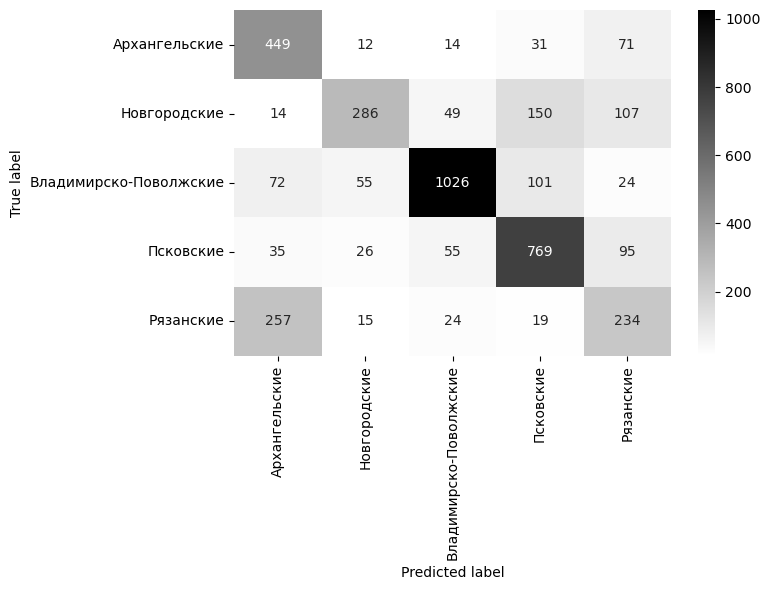

In [29]:
confusion_matrix(test['Variant'], test['predictions'])

## Test on data which not presented in dataset

## Yelets

In [30]:
yelets = pd.read_excel('manifest.xlsx')
yelets = yelets[yelets['corpus']=='Yelets']
yelets['Variant'] = 'Mezhzonalnie'
yelets = yelets[['path', 'Variant']]
yelets['array'] = yelets['path'].progress_apply(read_audio)
yelets['sampling_rate'] = 16000
yelets = yelets[['array', 'Variant']]
yelets['input_features'] = yelets['array'].progress_apply(prepare_dataset)

100%|███████████████████████████████████████████████████████████████████████████████| 522/522 [00:01<00:00, 336.26it/s]


In [31]:
yelets['predictions'] = yelets['input_features'].progress_apply(get_predictions)

100%|████████████████████████████████████████████████████████████████████████████████| 522/522 [00:39<00:00, 13.07it/s]


In [32]:
yelets['predictions'].value_counts()

Ryazanskie       248
Arkhangelskie    137
Pskovskie         93
Novgorodskie      38
Povolzkie          6
Name: predictions, dtype: int64

## Pskov

In [39]:
path1 = '/RNC_Pskov/pskov_luch'
pskov1 = [join(path1, f) for f in listdir(path1) if isfile(join(path1, f))]
path2 = '/RNC_Pskov/pskov_vedma'
pskov2 = [join(path2, f) for f in listdir(path2) if isfile(join(path2, f))]
pskov_test_rnc = pskov1 + pskov2
pskov_test_rnc_df = pd.DataFrame(pskov_test_rnc, columns=['path'])
pskov_test_rnc_df['Variant'] = 'Pskovskie'
pskov_test_rnc_df['array'] = pskov_test_rnc_df['path'].progress_apply(read_audio)
pskov_test_rnc_df['sampling_rate'] = 16000
pskov_test_rnc_df['input_features'] = pskov_test_rnc_df['array'].progress_apply(prepare_dataset)

100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 343.36it/s]


In [40]:
pskov_test_rnc_df = pskov_test_rnc_df[pskov_test_rnc_df['array'].str.len()>0]

In [41]:
pskov_test_rnc_df['predictions'] = pskov_test_rnc_df['input_features'].progress_apply(get_predictions)

100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:05<00:00, 13.02it/s]


In [42]:
pskov_test_rnc_df['predictions'].value_counts()

Novgorodskie     33
Pskovskie        20
Povolzkie        12
Arkhangelskie     2
Ryazanskie        1
Name: predictions, dtype: int64

# Whisper tiny fine-tuned (augmented)

In [12]:
model = AutoModelForAudioClassification.from_pretrained('/whisper-tiny-finetuned-rudialect-fixed-speakers-with-encoder-aug/model')
device = "cpu"
model.to(device)
test['predictions'] = test['input_features'].progress_apply(get_predictions)

100%|██████████████████████████████████████████████████████████████████████████████| 3990/3990 [05:05<00:00, 13.08it/s]


In [13]:
print(classification_report(test['Variant'], test['predictions']))

               precision    recall  f1-score   support

Arkhangelskie       0.54      0.82      0.65       577
 Novgorodskie       0.56      0.61      0.58       606
    Povolzkie       0.80      0.73      0.76      1278
    Pskovskie       0.76      0.65      0.70       980
   Ryazanskie       0.47      0.40      0.43       549

     accuracy                           0.66      3990
    macro avg       0.63      0.64      0.63      3990
 weighted avg       0.67      0.66      0.66      3990



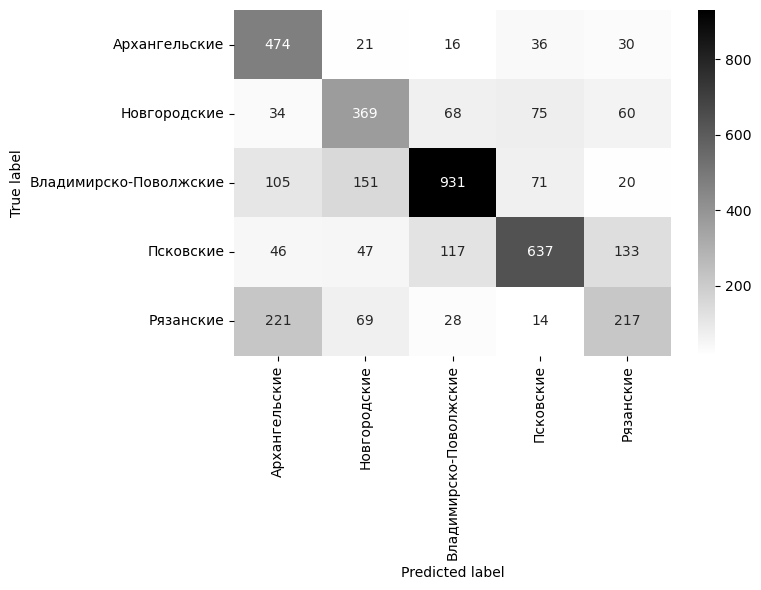

In [14]:
confusion_matrix(test['Variant'], test['predictions'])

# Test on data which not presented in dataset

## Yelets

In [15]:
yelets = pd.read_excel('manifest.xlsx')
yelets = yelets[yelets['corpus']=='Yelets']
yelets['Variant'] = 'Mezhzonalnie'
yelets = yelets[['path', 'Variant']]
yelets['array'] = yelets['path'].progress_apply(read_audio)
yelets['sampling_rate'] = 16000
yelets = yelets[['array', 'Variant']]
yelets['input_features'] = yelets['array'].progress_apply(prepare_dataset)

100%|███████████████████████████████████████████████████████████████████████████████| 522/522 [00:01<00:00, 309.36it/s]


In [16]:
yelets['predictions'] = yelets['input_features'].progress_apply(get_predictions)

100%|████████████████████████████████████████████████████████████████████████████████| 522/522 [00:39<00:00, 13.12it/s]


In [17]:
yelets['predictions'].value_counts()

Arkhangelskie    190
Ryazanskie       185
Novgorodskie     121
Pskovskie         21
Povolzkie          5
Name: predictions, dtype: int64

## Pskov

In [18]:
path1 = '/RNC_Pskov/pskov_luch'
pskov1 = [join(path1, f) for f in listdir(path1) if isfile(join(path1, f))]
path2 = '/RNC_Pskov/pskov_vedma'
pskov2 = [join(path2, f) for f in listdir(path2) if isfile(join(path2, f))]
pskov_test_rnc = pskov1 + pskov2
pskov_test_rnc_df = pd.DataFrame(pskov_test_rnc, columns=['path'])
pskov_test_rnc_df['Variant'] = 'Pskovskie'
pskov_test_rnc_df['array'] = pskov_test_rnc_df['path'].progress_apply(read_audio)
pskov_test_rnc_df['sampling_rate'] = 16000
pskov_test_rnc_df['input_features'] = pskov_test_rnc_df['array'].progress_apply(prepare_dataset)

100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 319.18it/s]


In [19]:
pskov_test_rnc_df = pskov_test_rnc_df[pskov_test_rnc_df['array'].str.len()>0]

In [20]:
pskov_test_rnc_df['predictions'] = pskov_test_rnc_df['input_features'].progress_apply(get_predictions)

100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:05<00:00, 13.09it/s]


In [21]:
pskov_test_rnc_df['predictions'].value_counts()

Novgorodskie     37
Pskovskie        21
Povolzkie         9
Arkhangelskie     1
Name: predictions, dtype: int64

# Whisper tiny fine-tuned (vanilla fine-tuning)

In [13]:
model = AutoModelForAudioClassification.from_pretrained('/whisper-tiny-finetuned-rudialect-fixed-speakers-trainallmodel/model')
device = "cpu"
model.to(device)
test['predictions'] = test['input_features'].progress_apply(get_predictions)

100%|██████████████████████████████████████████████████████████████████████████████| 3990/3990 [05:04<00:00, 13.10it/s]


In [14]:
print(classification_report(test['Variant'], test['predictions']))

               precision    recall  f1-score   support

Arkhangelskie       0.63      0.82      0.71       577
 Novgorodskie       0.55      0.36      0.44       606
    Povolzkie       0.95      0.91      0.93      1278
    Pskovskie       0.65      0.80      0.72       980
   Ryazanskie       0.65      0.49      0.56       549

     accuracy                           0.73      3990
    macro avg       0.69      0.68      0.67      3990
 weighted avg       0.73      0.73      0.72      3990



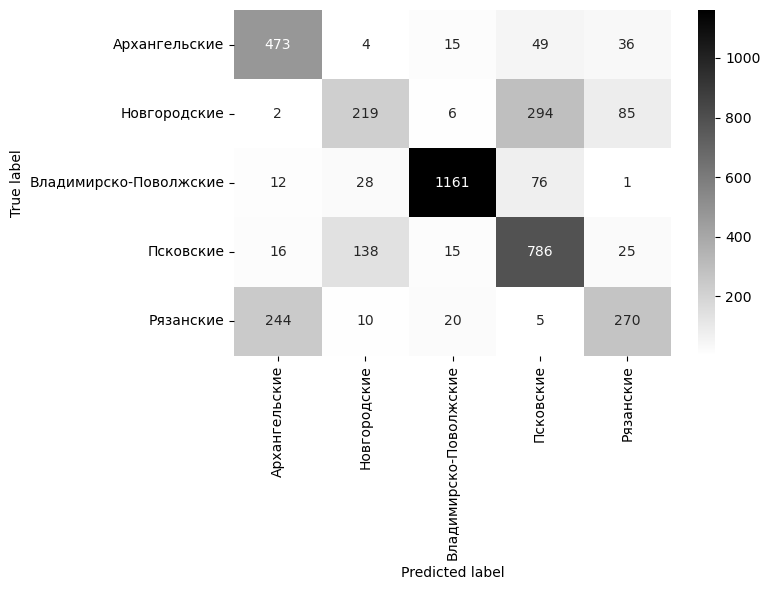

In [15]:
confusion_matrix(test['Variant'], test['predictions'])

# Test on data which not presented in dataset

## Yelets

In [16]:
yelets = pd.read_excel('manifest.xlsx')
yelets = yelets[yelets['corpus']=='Yelets']
yelets['Variant'] = 'Mezhzonalnie'
yelets = yelets[['path', 'Variant']]
yelets['array'] = yelets['path'].progress_apply(read_audio)
yelets['sampling_rate'] = 16000
yelets = yelets[['array', 'Variant']]
yelets['input_features'] = yelets['array'].progress_apply(prepare_dataset)
yelets['predictions'] = yelets['input_features'].progress_apply(get_predictions)
yelets['predictions'].value_counts()

100%|████████████████████████████████████████████████████████████████████████████████| 522/522 [00:39<00:00, 13.12it/s]


Ryazanskie       266
Pskovskie        112
Arkhangelskie     96
Novgorodskie      33
Povolzkie         15
Name: predictions, dtype: int64

## Pskov

In [17]:
path1 = '/RNC_Pskov/pskov_luch'
pskov1 = [join(path1, f) for f in listdir(path1) if isfile(join(path1, f))]
path2 = '/RNC_Pskov/pskov_vedma'
pskov2 = [join(path2, f) for f in listdir(path2) if isfile(join(path2, f))]
pskov_test_rnc = pskov1 + pskov2
pskov_test_rnc_df = pd.DataFrame(pskov_test_rnc, columns=['path'])
pskov_test_rnc_df['Variant'] = 'Pskovskie'
pskov_test_rnc_df['array'] = pskov_test_rnc_df['path'].progress_apply(read_audio)
pskov_test_rnc_df['sampling_rate'] = 16000
pskov_test_rnc_df['input_features'] = pskov_test_rnc_df['array'].progress_apply(prepare_dataset)
pskov_test_rnc_df = pskov_test_rnc_df[pskov_test_rnc_df['array'].str.len()>0]
pskov_test_rnc_df['predictions'] = pskov_test_rnc_df['input_features'].progress_apply(get_predictions)
pskov_test_rnc_df['predictions'].value_counts()

100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:05<00:00, 13.07it/s]


Pskovskie        20
Novgorodskie     20
Povolzkie        18
Arkhangelskie    10
Name: predictions, dtype: int64